In [1]:
"""

Extended Kalman Filter SLAM example

"""

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

References:
1. [Probabilistic Robotics](http://www.probabilistic-robotics.org/) book chapter 10.2 **SLAM with Extended Kalman Filters**.
2. Lecture notes of the [Robot Mapping class by Wolfram Burgard](http://ais.informatik.uni-freiburg.de/teaching/ws18/mapping/)

---
In this example, we used a simple 2D nonlinear dynamical system model. The state of the agent, $x$, is defined as:
$$
x = 
\begin{pmatrix} 
x & y & \theta
\end{pmatrix}^T
$$
where $x, y, \theta$ denotes the $x, y$ position and yaw angle of the agent, respectively.

The control of the system, $u$, is defined as:
$$
u = 
\begin{pmatrix} 
v & \omega
\end{pmatrix}^T
$$
where $v$ and $\omega$ denotes forward and angular velocity, respectively.

---
The (nonlinear) dynamics of motion model is given in the standard state-space form:
$$
x_t = Ax_{t-1} + Bu_t
$$
where
$$
A = 
\begin{pmatrix}
    1&0&0\\
    0&1&0\\
    0&0&1\\
\end{pmatrix}
$$
and 
$$
B = 
\begin{pmatrix}
    \Delta t \cos{\theta} & 0\\
    \Delta t \sin{\theta} & 0\\
    0 & \Delta t
\end{pmatrix}
$$
is the state (or system) matrix and input matrix, respectively.

---
The fundation of the Kalman filter is Bayesian filter where the posterior belief will be updated by the likelihood and a prior belief. In the Kalman filter, the belief is represented by two variables $\mu$ and $\Sigma$ which denotes the mean and covariance of the state. They are given by:
$$
\mu = 
\begin{pmatrix}
    x \\
    m
\end{pmatrix}
$$
and 
$$
\Sigma = 
\begin{pmatrix}
    \Sigma_{xx} & \Sigma_{xm} \\
    \Sigma_{mx} & \Sigma_{mm}
\end{pmatrix}
$$
where $x$ and $m$ denotes the agent's state and landmakrs, respectively.

---
The Kalman filter is a two step process. First we predict the new state based on our internal motion model. Then we update the predicted state and its covariance with the information brought by the new measurement and compute the best state estimation by weighting between predicted and inferred state according to the Kalman gain.

1. Prediction step:
$$
\begin{split}
    \bar{\mu}_t &= g(u_t, \mu_{t-1}) \\
    &= Fx^T A \mu_{t-1} + F_x^T \left( B u_t \right) \\
    &= 
    \mu_{t-1} + F_x^T 
    \begin{pmatrix}
        \Delta t \cos{\theta} & 0\\
        \Delta t \sin{\theta} & 0\\
        0 & \Delta t
    \end{pmatrix}
    \begin{pmatrix} 
    v_t \\
    \omega_t
    \end{pmatrix} \\
    &= \mu_{t-1} + F_x^T
    \begin{pmatrix}
        v_t \Delta t \cos{\theta}\\
        v_t \Delta t \sin{\theta}\\
        \omega_t \Delta t
    \end{pmatrix}    
\end{split}
$$
    where
$$
F_x = 
 \begin{pmatrix}
  1&0&0 & 0\cdots0 \\
  0&1&0 & 0\cdots0 \\
  0&0&1 & 0\cdots0 \\
 \end{pmatrix}
$$
    is an utility matrix that helps map matrices to the same shape as $\mu$
$$
\bar{\Sigma}_t = G_t \Sigma_{t-1} G_t^T + F_x^T R_t^x F_x
$$
    where 
$$
\begin{split}
G_t &= \frac{\partial}{\partial x} g(u_t, x_t) \\
&= \frac{\partial}{\partial x} \left( A_t x_{t-1} + B_t u_t \right) \\
&= A_t + \frac{\partial}{\partial x} \left( B_t u_t \right) \\
&= I + F_x^T g_t F_x
\end{split}
$$
    is the Jacobian of the (non-linear) motion function, and
$$
g_t = \frac{\partial}{\partial x} \left( B_t u_t \right)
$$
    is one of the two nonlinear functions $g(u_t, x_{t-1})$ and $h(x_t)$ locally linearized through first-order Taylor expansion:
$$
g(u_t, y_{t-1}) \approx g(u_t, \mu_{t-1}) + G_t(y_{t-1} - \mu_{t-1})
$$
    Prediction phase done!
2. Update step:
    The Kalman gain $K_t$ balances between the prior information carried from the predicted state using motion model ($\bar{\mu}_t$) and the inferred state from the new measurements. Finally we computes the weighted average between the two quantities and use that to update the final state for return.
    
    The range-bearing observation from the sensor is represented by:
$$
z_t^i = 
\begin{pmatrix}
    r_t^i \\
    \phi_t^i
\end{pmatrix}
$$
    where $z_t^i$ denotes sensor's $i$-th measurement at time $t$ and $r, \phi$ is the range-bearing observation. When we see a new landmark that has never been observed before, we will use the range-bearing observation and our current state estimate to compute an estimated landmark location $\bar{\mu}_j$. If the landmark has been observed before, we will use our current estimate of the landmark's location $$ and agent's location stored in the state matrix $x$ to compute the expected range-bearing observation at time $t$ for landmark $i$: $z_t^i$.
   
$$
\begin{pmatrix}
    \bar{\mu}_{j,x} \\
    \bar{\mu}_{j,y}
\end{pmatrix}
= 
\begin{pmatrix}
    \bar{\mu}_{t,x} \\
    \bar{\mu}_{t,y}
\end{pmatrix}
+
\begin{pmatrix}
    r_t^i \cos{\phi_t^i +\bar{\mu}_{t, \theta}} \\
    r_t^i \sin{\phi_t^i +\bar{\mu}_{t, \theta}}
\end{pmatrix}
$$

    

---

We define actual agent's state as $x$, and use $y$ to denote the combined feature:
$$
\begin{split}
y_t 
&= 
\begin{pmatrix}
    x_t\\
    m
\end{pmatrix} \\
&=
\begin{pmatrix}
    x_t & y_t & \theta_t \\
    m_{1,x} & m_{1,y} & 0\\
    m_{2,x} & m_{2,y} & 0\\
    \cdots & \cdots & \cdots \\
    m_{N,x} & m_{N,y} & 0\\
\end{pmatrix}
\end{split}
$$
where $m$ denotes the landmarks observed so far and $N$ is the total number of landmarks.

---
$$
F_{x,k} = 
 \begin{pmatrix}
  1&0&0 & & 0\cdots0 & & 0&0&0 & & 0\cdots0 \\
  0&1&0 & & 0\cdots0 & & 0&0&0 & & 0\cdots0 \\
  0&0&1 & & 0\cdots0 & & 0&0&0 & & 0\cdots0 \\
  \\
  0&0&0 & & 0\cdots0 & & 1&0&0 & & 0\cdots0 \\
  0&0&0 & & 0\cdots0 & & 0&1&0 & & 0\cdots0 \\
  0&0&0 & & 0\cdots0 & & 0&0&1 & & 0\cdots0 \\
 \end{pmatrix}
$$

$$
H_t^k = \frac{1}{q_k} 
\begin{pmatrix}
   \sqrt{q_k}\delta_{k,x} & -\sqrt{q_k}\delta_{k,y} & 0 & -\sqrt{q_k}\delta_{k,x} & \sqrt{q_k}\delta_{k,y} \\
   \delta_{k,y} & \delta_{k,x} & -1 & -\delta_{k,y} & -\delta_{k,x}
\end{pmatrix}
F_{x,k}
$$

---
Compute Kalman gain $K_t^i$:
$$
K_t^i = \bar{\Sigma}_t {H_t^i}^T \left( H_t^i \bar{\Sigma}_t {H_t^i}^T + Q_t\right)^{-1}
$$

---
We will use $g(u_t, x_{t-1})$ to represent the general form of the nonlinear motion functions.
$$
x_t = g(u_t, x_{t-1}) + \epsilon_t
= A_t x_{t-1} + B_t u_t + \epsilon_t
$$
In state-space representation, we can have the following form:
$$
g(u_t, x_{t-1}) = A_t x_{t-1} + B_t u_t
$$

Our measurement function takes the form of:
$$
z_t = h(x_t) + \delta_t
$$
where the nonlinear measurement function $h(x_t)$ can also be represented in state-space as:
$$
h(x_t) = C_t x_t
$$
where $C_t$ is the measurement matrix that defines the model of measurement (which maps state $x_t$ to measurement $z_t$).

In [2]:
class EKF_SLAM:
    show_animation = True
    
    # simulation parameters
    time_dt = 0.1     # time step [s]
    time_sim = 50.0   # total simulation time [s]
    ndim_state = 3    # state dimension [x, y, yaw]
    ndim_landmark = 2 # Landmark state dimension [x, y]
    sensor_max_range = 20.0 # maximum observation range of the simulated sensor
    m_dist_threshold = 2.0  # Threshold of Mahalanobis distance for data association.

    # EKF state covariance
    R_t = np.diag([0.5, 0.5, np.deg2rad(30.0)])**2

    #  Simulation parameter
    Qsim = np.diag([0.2, np.deg2rad(1.0)])**2   # Covariance of process noise
    Rsim = np.diag([1.0, np.deg2rad(10.0)])**2  # Covariance of measurement noise

    # landmark positions [x, y]
    landmarks = np.array(
        [[10.0, -2.0],
         [15.0, 10.0],
         [ 3.0, 15.0],
         [-5.0, 20.0],
         [ 8.0,  4.0],
         [-5.0, 10.0],
         [10.0, 15.0]
        ]
    )

    def __init__(self):
        if self.show_animation:
            self.fig = plt.figure()
            # plot ground truth landmarks
            self.line_lm, = plt.plot(self.landmarks[:, 0], self.landmarks[:, 1], "*k")
            # plot estimated of agent's location
            self.line_x_hat, = plt.plot(0, 0, ".r")
            # plot estimated landmarks
            self.line_lm_hat = []
            for i in range(self.landmarks.shape[0]):
                line, = plt.plot(0, 0, "xg")
                self.line_lm_hat.append(line)
            # plot histories
            self.line_hx, = plt.plot(0, 0, "-b")
            self.line_hx_dr, = plt.plot(0, 0, "-k")
            self.line_hx_hat, = plt.plot(0, 0, "-r")
            
            plt.axis("equal")
            plt.grid(True)
            plt.legend(
                [
                    self.line_hx, self.line_hx_dr, self.line_hx_hat,
                    self.line_x_hat, 
                    self.line_lm, self.line_lm_hat[0]
                ],
                [
                    'Agent path (truth)', 
                    'Agent path (DR)',
                    'Agent path (estimated)',
                    'Agent location (estimated)',
                    'Landmarks (truth)', 'Landmarks (estimated)'
                ],
                loc='best'
            )
            self.fig.canvas.draw()

    
    def run(self):
        # state Vector [x y yaw]'
        x_hat = np.matrix(np.zeros((self.ndim_state, 1)))
        x = np.matrix(np.zeros((self.ndim_state, 1)))
        # state covariance estimate (initialize to identity)
        P_hat = np.eye(self.ndim_state)
        # Dead reckoning
        x_dr = np.matrix(np.zeros((self.ndim_state, 1)))  
        # history
        h_x = x
        h_x_hat = x_hat
        h_x_dr = x
        
        if self.show_animation:
            self.line_lm.set_xdata(self.landmarks[:, 0])
        time = 0.0
        while self.time_sim >= time:
            time += self.time_dt
            # get new control
            u = self.get_u()
            # take new observation
            x, z, x_dr, ud = self.observation(x, x_dr, u, self.landmarks)
            # update state and covariance
            x_hat, P_hat = self.ekf_slam(x_hat, P_hat, ud, z)
            # get agent state
            x_state = x_hat[0:self.ndim_state]

            # store data history
            h_x     = np.hstack((h_x, x))
            h_x_hat = np.hstack((h_x_hat, x_state))
            h_x_dr  = np.hstack((h_x_dr, x_dr))
            
            if self.show_animation:
                # estimated of agent's location
                self.line_x_hat.set_xdata(x_hat[0])
                self.line_x_hat.set_ydata(x_hat[1])
                # estimated landmarks
                for i in range(self.count_landmarks(x_hat)):
                    self.line_lm_hat[i].set_xdata(x_hat[self.ndim_state + i*2])
                    self.line_lm_hat[i].set_ydata(x_hat[self.ndim_state + i*2 + 1])
                self.line_hx.set_xdata(np.array(h_x[0, :]).flatten())
                self.line_hx.set_ydata(np.array(h_x[1, :]).flatten())
                self.line_hx_dr.set_xdata(np.array(h_x_dr[0, :]).flatten())
                self.line_hx_dr.set_ydata(np.array(h_x_dr[1, :]).flatten())
                self.line_hx_hat.set_xdata(np.array(h_x_hat[0, :]).flatten())
                self.line_hx_hat.set_ydata(np.array(h_x_hat[1, :]).flatten())
                plt.pause(0.01)
                self.fig.canvas.draw()
        
    def get_u(self):
        v = 1.0        # [m/s]
        yawrate = 0.1  # [rad/s]
        u = np.matrix([v, yawrate]).T
        return u

    def motion_model(self, x, u):
        # https://en.wikipedia.org/wiki/State-space_representation
        # state matrix 3x3
        A = np.matrix([[1.0, 0, 0],
                       [0, 1.0, 0],
                       [0, 0, 1.0]])
        # input matrix 3x2
        B = np.matrix([[self.time_dt * np.cos(x[2, 0]), 0],
                       [self.time_dt * np.sin(x[2, 0]), 0],
                       [0.0, self.time_dt]])
        # update state vector
        x = A * x + B * u
        return x
    
    def count_landmarks(self, x):
        # count number of landmarks in x
        n = (len(x) - self.ndim_state) // self.ndim_landmark
        return n

    def get_landmark_pos(self, x, z):
        '''
        Compute landmark position from range-bearing measurement
        and current agent's state estimate
        '''
        zp = np.zeros((2, 1))
        zp[0, 0] = x[0, 0] + z[0, 0] * np.cos(x[2, 0] + z[0, 1])
        zp[1, 0] = x[1, 0] + z[0, 0] * np.sin(x[2, 0] + z[0, 1])
        return zp

    def get_landmark_pos_from_state(self, x, idx):
        # get the idx-th landmark position from state matrix
        lm = x[(self.ndim_state + self.ndim_landmark * idx) : (self.ndim_state + self.ndim_landmark * (idx + 1)), :]
        return lm

    def offset_angle(self, angle):
        # make sure angle is from 0 to 2*pi
        return (angle + np.pi) % (2 * np.pi) - np.pi

    def search_landmark_id(self, xAug, PAug, zi):
        '''
        Find and return the landmark that minimizes the Mahalanobis distance from the agent
        '''
        nLM = self.count_landmarks(xAug)
        min_dist = self.m_dist_threshold
        min_idx = nLM
        for i in range(nLM):
            lm = self.get_landmark_pos_from_state(xAug, i)
            y, S, H = self.calc_innovation(i, lm, xAug, PAug, zi)
            mdist = y.T * np.linalg.inv(S) * y
            if mdist < min_dist:
                min_dist = mdist
                min_idx = i
            
        return min_idx

    def jacobian_motion(self, x, u):
        '''
        Jacobian of motion function g
        '''
        # mapping matrix Fx helps map actual state vector (dim_state)
        # into combined state vector (dim_state + dim_landmark*cnt_landmark)
        Fx = np.hstack(
            (
                np.eye(self.ndim_state),
                np.zeros((self.ndim_state, self.ndim_landmark * self.count_landmarks(x)))
            )
        )
        jBu = np.matrix([[0.0, 0.0, -self.time_dt * u[0] * np.sin(x[2, 0])],
                        [0.0, 0.0,   self.time_dt * u[0] * np.cos(x[2, 0])],
                        [0.0, 0.0, 0.0]])

        G = np.eye(self.ndim_state) + Fx.T * jBu * Fx

        return G, Fx
    
    def jacobian_H(self, q, sq, delta, x, i):
        '''
        Jacobian of measurement function h
        
        INPUT:
            q : squared delta_k
            sq: square root of q
            delta: location error between landmark i and agent
            x: current state
            i: index of current landmark
            
        OUTPUT:
            H: Jacobian of measurement function h
        '''
        G = np.matrix(
            [
                [-sq * delta[0, 0], - sq * delta[1, 0], 0, sq * delta[0, 0], sq * delta[1, 0]],
                [delta[1, 0], - delta[0, 0], - 1.0, - delta[1, 0], delta[0, 0]]
            ]
        )
        G = G / q
        # mapping matrix Fx helps map actual state vector (dim_state)
        # into combined state vector (dim_state + dim_landmark*cnt_landmark)
        num_landmarks = self.count_landmarks(x)
        Fx = np.hstack(
            (
                np.eye(self.ndim_state),
                np.zeros((self.ndim_state, self.ndim_landmark * num_landmarks))
            )
        ) # upper half of F_xk
        Fk = np.hstack(
            (
                np.zeros((self.ndim_landmark, self.ndim_state)), 
                np.zeros((self.ndim_landmark, self.ndim_landmark * (i - 1))),
                np.eye(self.ndim_landmark), 
                np.zeros((self.ndim_landmark, self.ndim_landmark * num_landmarks - self.ndim_landmark * i))
            )
        ) # lower half of F_xk
        F_xk = np.vstack((Fx, Fk))
        H = G * F_xk
        return H
   
    def observation(self, x, x_hat, u, landmarks):
        # update new true state
        x = self.motion_model(x, u)

        # measurement noise
        z = np.matrix(np.zeros((0, self.ndim_state)))
        # loop through all landmarks and append to measurement matrix if valid
        num_landmarks = len(landmarks[:, 0])
        for i in range(num_landmarks):
            dx = landmarks[i, 0] - x[0, 0]  # x distance from i-th landmark to the position
            dy = landmarks[i, 1] - x[1, 0]  # y distance from i-th landmark to the position
            d = np.sqrt(dx**2 + dy**2)      # true l-2 distance between landmark and current true position
            angle = self.offset_angle(np.arctan2(dy, dx)) # true angle measurement
            if d <= self.sensor_max_range:
                # if the landmark is in the detactable range of the sensor
                d_hat = d + np.random.randn() * self.Qsim[0, 0]          # measured distance plus process noise
                angle_hat = angle + np.random.randn() * self.Qsim[1, 1]  # measured angle plus process noise
                # put together the measurement matrix for the i-th landmark
                zi = np.matrix([d_hat, angle_hat, i]) # measurement of i-th landmark
                z = np.vstack((z, zi))                # all measurements

        # add control noise to all input u dimensions
        ndim_u = len(u[:, 0])
        u_dims = []
        for i in range(ndim_u):
            u_dims.append(u[i, 0] + np.random.randn() * self.Rsim[i, i])    
        u_hat = np.matrix(u_dims).T
        # predict new state with predicted x and u
        # this is the dead reckoning state estimation x_dr
        x_hat = self.motion_model(x_hat, u_hat)
        return x, z, x_hat, u_hat
    
    def calc_innovation(self, landmark_idx, landmark, x_hat, P_hat, z):
        # location delta
        delta = landmark - x_hat[0:2] 
        # predicted distance measurement
        q = (delta.T * delta)[0, 0]   
        sq = np.sqrt(q)
        # predicted angle measurement
        z_angle = np.arctan2(delta[1], delta[0]) - x_hat[2] 
        # put together, z_hat = predicted measurement vector
        z_hat = [sq, self.offset_angle(z_angle)]
        # innovation
        y = (z - z_hat).T
        y[1] = self.offset_angle(y[1])
        # Jacobian of measurement function
        H = self.jacobian_H(q, sq, delta, x_hat, landmark_idx + 1)
        # compute S, P_hat is the estimated covariance of measurement
        # and R_t is the pre-defined covariance of state 
        # (we are only using) the upper-left 2-by-2 
        S = H * P_hat * H.T + self.R_t[0:2, 0:2]
        
        return y, S, H
    
    def ekf_slam(self, x_hat, P_hat, u, z):
        # Predict
        nS = self.ndim_state
        x_hat[0:nS] = self.motion_model(x_hat[0:nS], u)
        G, Fx = self.jacobian_motion(x_hat[0:nS], u)
        P_hat[0:nS, 0:nS] = G.T * P_hat[0:nS, 0:nS] * G + Fx.T * self.R_t * Fx
        P_init = np.eye(2) # initialize covariance matrix to identify
        
        # Update
        ndim_z = len(z[:, 0])
        for iz in range(ndim_z):  # for each observation
            lm_id = self.search_landmark_id(x_hat, P_hat, z[iz, 0:2])
            nLM = self.count_landmarks(x_hat)
            if lm_id == nLM:
                print(f'Found new landmark (total {nLM+1})')
                # Extend state and covariance matrix
                x_tmp = np.vstack((x_hat, self.get_landmark_pos(x_hat, z[iz, :])))
                P_hat = np.vstack(
                    (
                        np.hstack((P_hat, np.zeros((len(x_hat), self.ndim_landmark)))),
                        np.hstack((np.zeros((self.ndim_landmark, len(x_hat))), P_init))
                    )
                )
                x_hat = x_tmp
            
            lm = self.get_landmark_pos_from_state(x_hat, lm_id)
            y, S, H = self.calc_innovation(lm_id, lm, x_hat, P_hat, z[iz, 0:2])
            # Kalman gain
            K = P_hat * H.T * np.linalg.inv(S)
            x_hat = x_hat + K * y
            P_hat = (np.eye(len(x_hat)) - K * H) * P_hat

        x_hat[2] = self.offset_angle(x_hat[2])

        return x_hat, P_hat


<IPython.core.display.Javascript object>


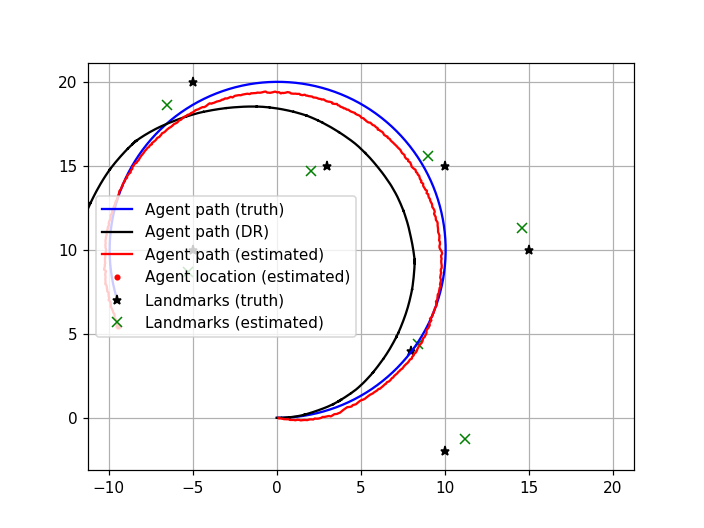

Found new landmark (total 1)
Found new landmark (total 2)
Found new landmark (total 3)
Found new landmark (total 4)
Found new landmark (total 5)
Found new landmark (total 6)
Found new landmark (total 7)


In [3]:
ekf = EKF_SLAM()
ekf.run()